In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import linregress
from scipy.stats import ttest_ind
import statsmodels.stats.power as smp
from sklearn.model_selection import train_test_split

In [2]:
df_processes=pd.read_csv("data/processes.csv",sep='\t')
df_connections = pd.read_csv("data/connections.csv", sep='\t')
df_processes.head()


,ts,imei,mwra,p.android.chrome,p.android.externalstorage,p.android.gm,p.android.packageinstaller,p.android.settings,p.android.documentsui,p.system,...,p.inputmethod.latin,p.android.vending,p.notifier,p.katana,p.browser.provider,p.olauncher,p.process.gapps,p.google,p.android.defcontainer,p.dogalize
0,2018-05-05 10:00:00,359043379931766817,0.0,12.67131,11.51584,11.14770,16.65822,10.34567,13.85827,14.24441,...,67.41099,43.41425,76.85292,61.49504,83.84273,90.26474,64.52255,58.33299,53.62833,71.56538
1,2018-05-05 10:01:00,8630330696303481313,1.0,14.37083,10.40542,9.51907,16.41548,8.97598,13.02322,16.31514,...,63.46175,41.06191,96.50752,90.91460,28.28500,8.85422,51.89787,15.59966,73.88848,8.64346
2,2018-05-05 10:02:00,8630330696303482485,1.0,15.29793,11.57740,13.15840,11.13504,12.78871,15.33671,18.05368,...,61.37235,41.14340,14.49331,74.73880,4.18073,6.10243,44.94162,60.25186,74.62467,43.83823
3,2018-05-05 10:03:00,8630330696303481628,0.0,17.46341,11.75419,11.61736,12.61226,9.20242,11.43078,9.84154,...,43.42172,49.29721,21.64738,71.05116,62.98376,44.42369,51.61388,13.60374,19.42437,1.84968
4,2018-05-05 10:04:00,359043379931766957,0.0,10.87997,12.62410,13.19246,13.77152,15.48980,14.81432,14.67672,...,48.06657,70.43036,90.86824,42.66690,60.74888,50.69262,24.46560,70.89736,46.68829,36.31749


<Axes: >

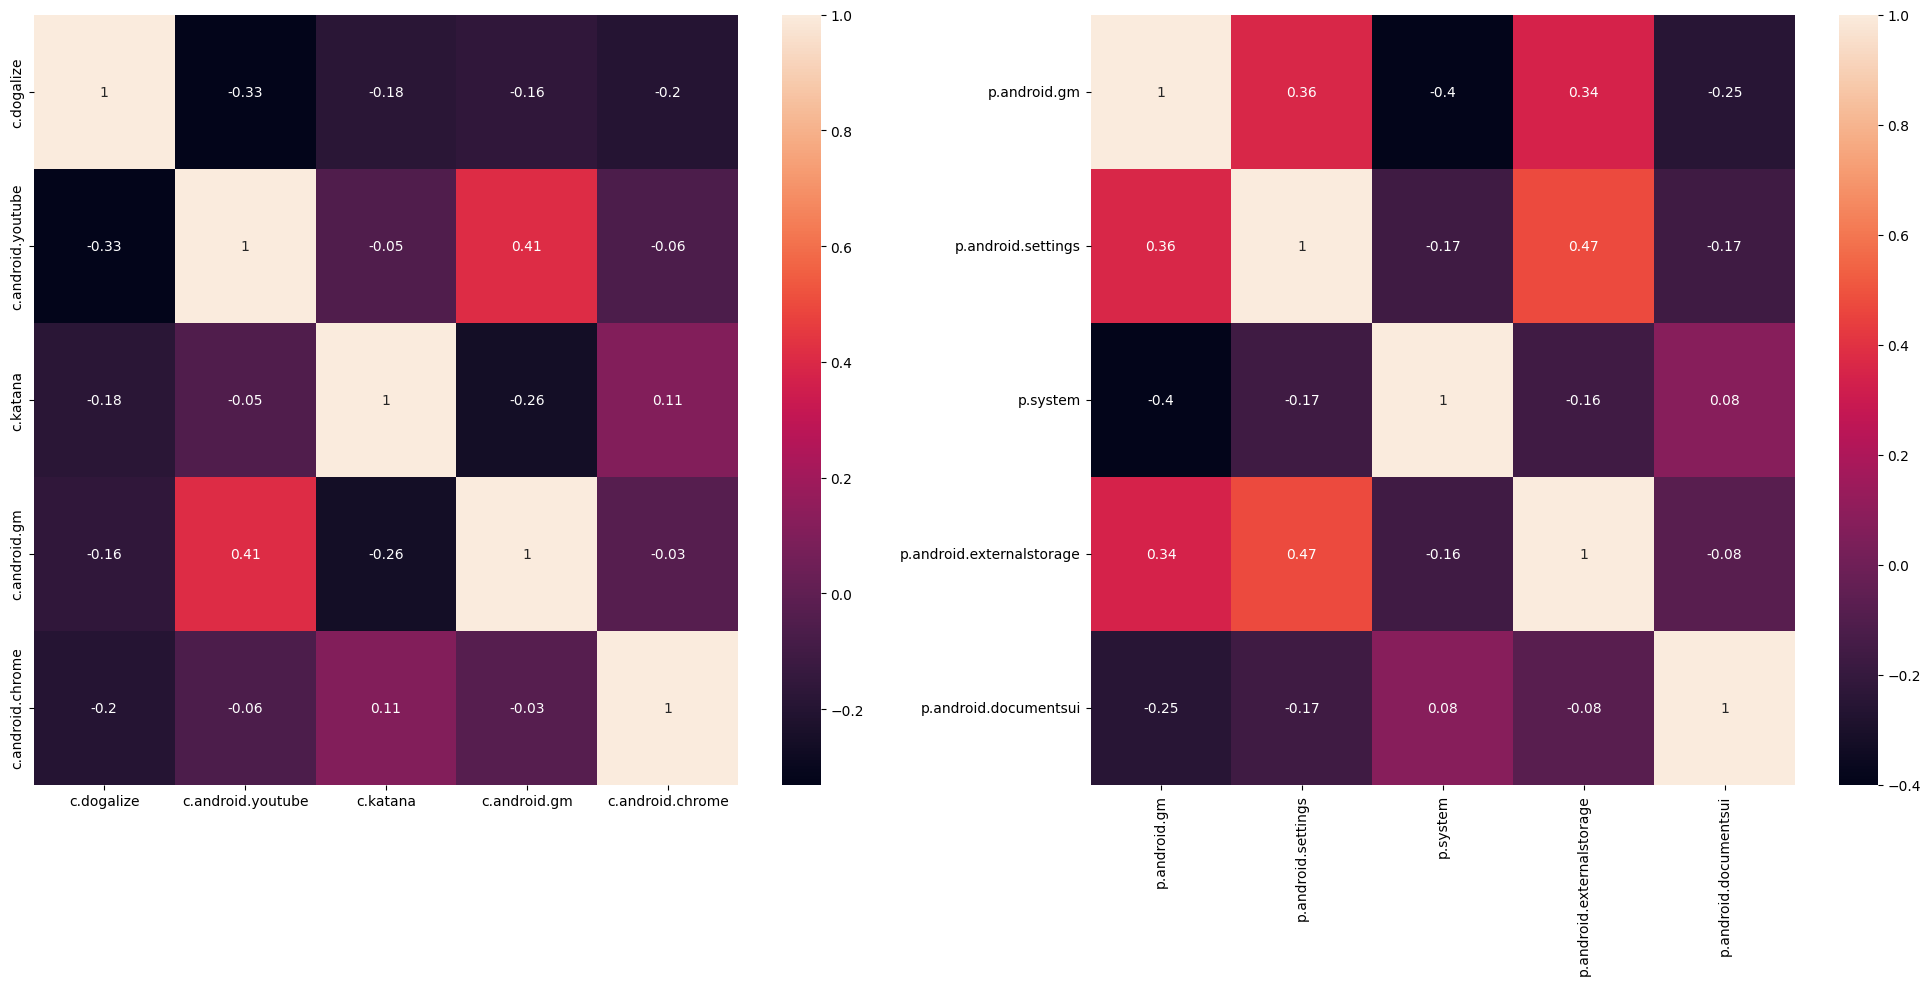

In [3]:
plt.figure(figsize=(25,10))
df_connections=df_connections[df_connections.columns[3:8]]
df_connections.drop_duplicates(inplace=True)
plt.subplot(1,2,1)
sns.heatmap(df_connections.iloc[:,:].corr().round(decimals=2),annot=True)
df_processes=df_processes[['p.android.gm','p.android.settings','p.system','p.android.externalstorage','p.android.documentsui']]

df_processes.drop_duplicates(inplace=True)
plt.subplot(1,2,2)
sns.heatmap(df_processes.iloc[:,:].corr().round(decimals=2),annot=True)


In [4]:
df_processes_train, df_processes_test = train_test_split(df_processes, test_size=0.2, random_state=42)
print(df_processes_train.shape,df_processes_test.shape)

(12109, 5) (3028, 5)


In [5]:
df_connections_train, df_connections_test = train_test_split(df_connections, test_size=0.2, random_state=42)
print(df_connections_train.shape,df_connections_test.shape)


(12109, 5) (3028, 5)
